In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch

import galactic_wavelets as gw

In [2]:
quijote_dir = '/mnt/ceph/users/fvillaescusa/Quijote/3D_cubes/'
df_fname = 'fiducial/0/df_m_128_CIC_z=0.npy'
dx = 1000.0/128.0 # Mpc/h
kmax = np.pi/dx
device = 0

In [3]:
df = torch.from_numpy(np.load(os.path.join(quijote_dir, df_fname))).to(device)
df_shape = df.shape
N = df_shape[0]

In [4]:
J = 3
Q = 4
kc = 2*np.pi/3 # Cutoff frequency of the mother wavelet (in px^-1 units)
moments = [1/2, 1, 2]

In [5]:
wst_op = gw.ScatteringOp(df_shape, J, Q,
                         moments=moments,
                         kc=kc,
                         scattering=True,
                         device=device)

Computing wavelets...
Done!


In [6]:
s0, s1, s2 = wst_op(df)

Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Computing S2 coefficients...
Done!


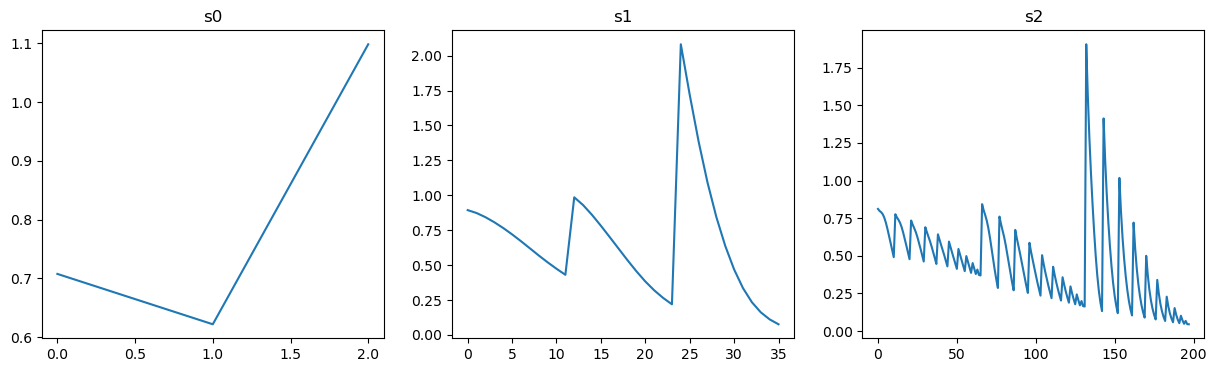

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(s0.cpu().numpy())
axs[1].plot(s1.cpu().numpy().flatten())
axs[2].plot(s2.cpu().numpy().flatten())
axs[0].set_title('s0')
axs[1].set_title('s1')
axs[2].set_title('s2')
plt.show()

In [8]:
fw = torch.fft.fftshift(wst_op.wt_op.get_wavelets("fourier").squeeze(), dim=(-3, -2, -1))
w = torch.fft.fftshift(wst_op.wt_op.get_wavelets("physical").squeeze(), dim=(-3, -2, -1))

w_renorm = w.clone()
for j in range(J):
    for q in range(Q):
        w_renorm[j*Q + q] *= 2**(3*(j*Q + q)/Q)
aw_renorm = torch.absolute(w_renorm)

physical_units = True
if physical_units:
    sampling_step = np.pi/kmax
    xvals = np.arange(-N//2, N//2)*sampling_step
    kvals = np.fft.fftshift(2*np.pi*np.fft.fftfreq(N, sampling_step))
else:
    sampling_step = 1.0
    xvals = np.arange(-N//2, N//2)*sampling_step
    kvals = np.fft.fftshift(2*np.pi*np.fft.fftfreq(N, sampling_step))

NameError: name 'erosion_threshold' is not defined

/mnt/sw/nix/store/mpgyydv1wg7wwirp67ds6f2psq63s2p1-python-3.8.16-view/lib/python3.8/site-packages/torch/_tensor.py:972: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/tmp/ipykernel_2663535/3231133691.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


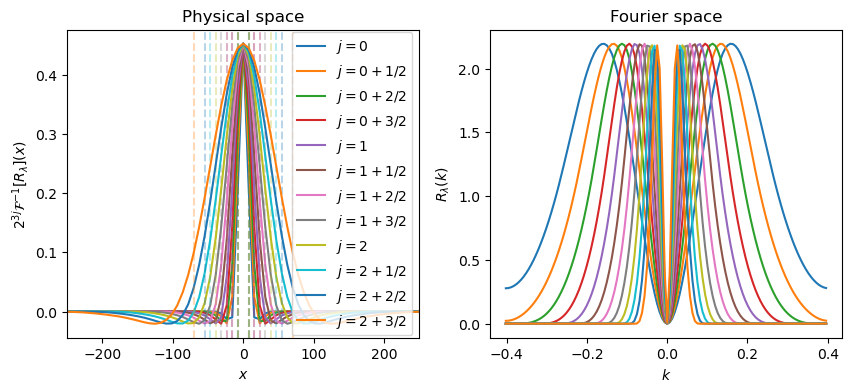

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for j in range(J):
    for q in range(Q):
        p = axs[0].plot(xvals, w_renorm[j*Q + q, N//2, N//2, :].cpu(), label=f"$j={j} + {q}/2$" if q != 0 else f"$j={j}$")
        axs[1].plot(kvals, fw[j*Q + q, N//2, N//2, :].cpu())

axs[0].legend()
axs[0].set_xlim(-N//4 * sampling_step, N//4 * sampling_step)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel(r"$2^{3j}\mathcal{F}^{-1}[R_\lambda](x)$")
axs[0].set_title("Physical space")

axs[1].set_xlabel("$k$")
axs[1].set_ylabel(r"$R_\lambda(k)$")
axs[1].set_title("Fourier space")

fig.show()